In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os
import zipfile
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets
from torchvision.io import read_image
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
%matplotlib inline

device = "cuda" if torch.cuda.is_available() else "cpu"
data_path = '/content/drive/MyDrive/Colab/lab/GAN/data/'


Mounted at /content/drive


In [2]:
# unzip images if needed
if not os.path.exists('/content/Images'):
    with zipfile.ZipFile(data_path + 'Images.zip', "r") as zip_ref:
        zip_ref.extractall()
os.listdir('Images')[:3]


['Patient00948_Plane4_2_of_2.png',
 'Patient00873_Plane3_1_of_3.png',
 'Patient01215_Plane6_1_of_1.png']

# 0. Data Preprocessing

In [3]:
df = pd.read_csv(data_path+'FETAL_PLANES_DB_data.csv', delimiter=';')
df.head()


,Image_name,Patient_num,Plane,Brain_plane,Operator,US_Machine,Train
0,Patient00001_Plane1_1_of_15,1,Other,Not A Brain,Other,Aloka,1
1,Patient00001_Plane1_2_of_15,1,Other,Not A Brain,Other,Aloka,1
2,Patient00001_Plane1_3_of_15,1,Other,Not A Brain,Other,Aloka,1
3,Patient00001_Plane1_4_of_15,1,Other,Not A Brain,Other,Aloka,1
4,Patient00001_Plane1_5_of_15,1,Other,Not A Brain,Other,Aloka,1


In [4]:
df = df[df['Plane']=='Fetal brain']
df['Brain_plane'].unique()


array(['Trans-thalamic', 'Trans-cerebellum', 'Trans-ventricular', 'Other'],
      dtype=object)

In [5]:
labels_dict = {
    'Trans-thalamic': 0,
    'Trans-cerebellum': 1,
    'Trans-ventricular': 2
}


In [6]:
df = df[df['Brain_plane']!='Other'].reset_index()
df['Brain_plane'] = df['Brain_plane'].apply(lambda x: labels_dict[x])
df.rename(columns={"Train ": 'Train', 'Brain_plane': 'Label'}, inplace=True)
df = df[['Image_name', 'Label', 'Train']]
df.head()


,Image_name,Label,Train
0,Patient00168_Plane3_1_of_3,0,1
1,Patient00168_Plane3_2_of_3,0,1
2,Patient00168_Plane3_3_of_3,1,1
3,Patient00188_Plane3_1_of_3,0,1
4,Patient00188_Plane3_2_of_3,2,1


In [7]:
df.shape


(2949, 3)

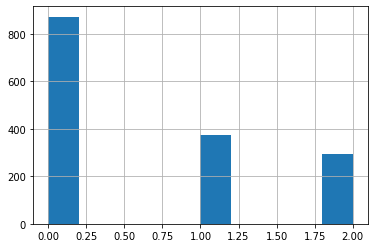

In [8]:
df[df['Train']==1]['Label'].hist()


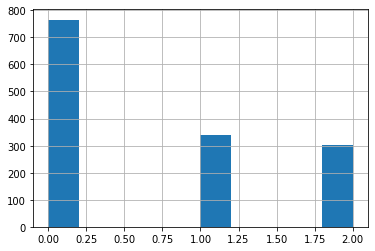

In [9]:
df[df['Train']==0]['Label'].hist()


# 1. Prepare Image Dataset

In [10]:
# image_paths = [f'Images/{i}.png' for i in df['Image_name'].values]
# image_data = torch.cat([transforms(Image.open(i)) for i in image_paths])
# torch.mean(image_data), torch.std(image_data)


In [11]:
# Apply transformation
transforms = Compose([
    Resize((224, 224)),
    ToTensor(),
    Normalize([0.5], [0.5])    # ([0~1] - 0.5) / 0.5
])


In [12]:
class ImageDataset(Dataset):
    """
    A customized dataset class that loads images from folder from pytorch.
    args:
    - df: pre-processed dataframe
    - directory: location of the images
    - transform: transform function to apply to the images
    - extension: file format
    """
    def __init__(self,
                 df,
                 transforms=None,
                 directory='Images/',
                 extension='.png'):
        self.img_labels = df
        self.transforms = transforms
        self.directory = directory
        self.extension = extension

    def __len__(self):
        """ returns the number of items in the dataset """
        return self.img_labels.shape[0]

    def __getitem__(self, idx):
        """ load an image and apply transformation """
        image_path = os.path.join(
            self.directory,
            self.img_labels.iloc[idx, 0] + self.extension)
        image = Image.open(image_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transforms:
            image = self.transforms(image)
        return image, label


In [13]:
def denormalize(image):
    return ((image + 1.) / 2. * 255).type(torch.uint8)


In [14]:
training_data = ImageDataset(df[df['Train']==1], transforms)
test_data = ImageDataset(df[df['Train']==0], transforms)


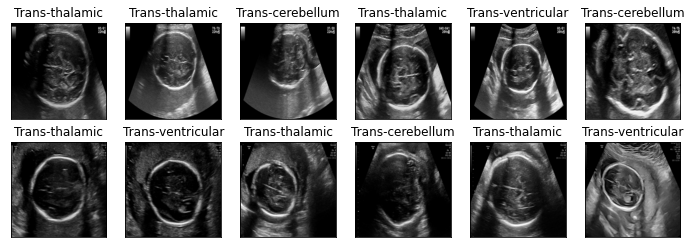

<Figure size 432x288 with 0 Axes>

In [15]:
fig = plt.figure(figsize=(12, 4))
plot_size=12
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, int(plot_size/2), idx+1, xticks=[], yticks=[])
    labels = [k for k, v in labels_dict.items() if v==training_data[idx][1]][0]
    ax.title.set_text(labels)
    img = denormalize(training_data[idx][0]).squeeze().numpy()
    ax.imshow(img, cmap='gray')

plt.show()
plt.clf()


# 2. Model Implementation

## Discriminator

output size = [(W−K+2P)/S]+1

W - input volume<br>
K - kernel size<br>
P - padding<br>
S - stride<br>

In [16]:
class Discriminator(nn.Module):
    """
    discriminator input:
        image: Batch size, channel(1), Height(224), Weight(224)
        label: Batch size,
    """
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(2, 32, 4, stride=2, padding=1, bias=False), # 32 x 112 x 112
            nn.LeakyReLU(0.2),
            nn.Conv2d(32, 64, 4, stride=2, padding=1, bias=False), # 64 x 56 x 56
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, stride=2, padding=1, bias=False), # 128 x 28 x 28
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, 4, stride=2, padding=1, bias=False), # 256 x 14 x 14
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 512, 4, stride=2, padding=1, bias=False), # 512 x 7 x 7
            nn.LeakyReLU(0.2),
            nn.utils.spectral_norm(nn.Conv2d(512, 1, 7, stride=2, padding=1, bias=False)) # 1 x 1 x 1
        )

        self.label_linear = nn.Sequential(
            nn.Embedding(3, 100),
            nn.utils.spectral_norm(nn.Linear(100, 224*224))
        )

    def forward(self, img, label):
        y = self.label_linear(label).view(len(label), 1, 224, 224)
        x = torch.cat([img, y], dim=1)
        x = self.conv(x)
        return x


## Generator

In [17]:
class Generator(nn.Module):
    """
    generator input:
        latent:  Batch size, latent dim
        label: Batch size,
    """
    def __init__(self, latent_dim):
        super().__init__()

        self.label_embed = nn.utils.spectral_norm(nn.Embedding(3, 100))
        self.label_convT = nn.ConvTranspose2d(100, 256, 7, stride=1, padding=0, bias=False) # 256 x 7 x 7
        self.latent_convT = nn.ConvTranspose2d(latent_dim, 256, 7, stride=1, padding=0, bias=False) # 256 x 7 x 7

        self.convT = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1, bias=False), # 256 x 14 x 14
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1, bias=False), # 128 x 28 x 28
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1, bias=False), # 64 x 56 x 56
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1, bias=False), # 32 x 112 x 112
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 4, stride=2, padding=1, bias=False), # 1 x 224 x 224
            nn.Tanh()
        )

    def forward(self, x, label):
        y = self.label_embed(label).view(len(label), -1, 1, 1)
        y = self.label_convT(y)
        h = self.latent_convT(x)
        x = torch.cat([h, y], dim=1)
        x = self.convT(x)
        return x


## Weights

In [18]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)


# 3. Loss

In [19]:
def generator_loss(fake_logits):
    """ BCE loss, takes the fake scores as inputs. """
    criterion = nn.BCEWithLogitsLoss()
    label = torch.ones_like(fake_logits) * 0.9
    label = label.to(device).requires_grad_(False)
    g_loss = criterion(fake_logits, label)
    return g_loss


In [20]:
def discriminator_loss(real_logits, fake_logits):
    """ BCE loss, takes the fake and real logits as inputs. """
    r_label = torch.ones_like(real_logits) * 0.9 # smooth
    r_label = r_label.to(device).requires_grad_(False)
    f_label = torch.zeros_like(fake_logits)
    f_label = f_label.to(device).requires_grad_(False)
    criterion = nn.BCEWithLogitsLoss()
    r_loss = criterion(real_logits, r_label)
    f_loss = criterion(fake_logits, f_label)
    d_loss = r_loss + f_loss
    return d_loss/2


# 4. Single Training Step

In [21]:
def generator_step(batch_size, latent_dim):
    """ One training step of the generator. """
    g_optimizer.zero_grad()

    latent = np.random.uniform(-1, 1, size=(batch_size, latent_dim, 1, 1))
    latent = torch.from_numpy(latent).float().requires_grad_(False).to(device)
    label = torch.randint(3, (batch_size,), requires_grad=False).to(device)

    fake_images = generator(latent, label)
    d_fake = discriminator(fake_images, label)
    g_loss = generator_loss(d_fake)
    g_loss.backward()
    g_optimizer.step()
    return {'loss': g_loss}


def discriminator_step(batch_size, latent_dim, real_images, real_labels):
    """ One training step of the discriminator. """
    d_optimizer.zero_grad()
    d_real = discriminator(real_images, real_labels)

    latent = np.random.uniform(-1, 1, size=(batch_size, latent_dim, 1, 1))
    latent = torch.from_numpy(latent).float().requires_grad_(False).to(device)
    label = torch.randint(3, (batch_size,), requires_grad=False).to(device)

    fake_images = generator(latent, label)
    d_fake = discriminator(fake_images.detach(), label)
    # gp = gradient_penalty(real_images, real_labels, discriminator)
    # d_loss = discriminator_loss(d_real, d_fake) + gp * gp_weight
    d_loss = discriminator_loss(d_real, d_fake)
    d_loss.backward()
    d_optimizer.step()
    
    return {'loss': d_loss}


In [22]:
latent_dim = 128
n_epochs = 50
batch_size = 64
lr = 0.0002
beta1 = 0.5
beta2 = 0.999
print_every = 15


In [23]:
train_dataloader = DataLoader(training_data, batch_size, num_workers=2, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size, num_workers=2, shuffle=True)
discriminator = Discriminator().to(device)
discriminator.apply(weights_init_normal)
generator = Generator(latent_dim).to(device)
generator.apply(weights_init_normal)

d_optimizer = torch.optim.Adam(discriminator.parameters(), lr, [beta1, beta2])
g_optimizer = torch.optim.Adam(generator.parameters(), lr, [beta1, beta2])


In [24]:
def display(generated_images, fixed_labels):
    """ helper function to display images during training """
    fig = plt.figure(figsize=(12, 4))
    plot_size = 12
    labels = fixed_labels.squeeze().detach().cpu()
    for idx in np.arange(plot_size):
        ax = fig.add_subplot(2, int(plot_size/2), idx+1, xticks=[], yticks=[])
        label = [k for k, v in labels_dict.items() if v==labels[idx]][0]
        ax.title.set_text(label)
        img = denormalize(generated_images[idx]).squeeze().detach().cpu().numpy()
        ax.imshow(img, cmap='gray')
    plt.show()
    plt.clf()


In [25]:
# Load previous model if needed

# discriminator.load_state_dict(torch.load(data_path+'discriminator_v02sn_epoch_100.pt'))
# generator.load_state_dict(torch.load(data_path+'generator_v02sn_epoch_100.pt'))


<All keys matched successfully>

In [43]:
fixed_latent_vector = torch.randn(12, latent_dim, 1, 1).float().to(device)
fixed_labels = torch.tensor([0,0,1,1,2,2,0,0,1,1,2,2]).to(device)

losses = []
discriminator.train()
generator.train()

# n_epochs
for epoch in range(n_epochs):
    for i, (real_images, real_labels) in enumerate(train_dataloader):
        real_images = real_images.to(device)
        real_labels = real_labels.to(device)

        d_loss = discriminator_step(batch_size, latent_dim, real_images, real_labels)
        g_loss = generator_step(batch_size, latent_dim)
        
        if i % print_every == 0:
            # append discriminator loss and generator loss
            d = d_loss['loss'].item()
            g = g_loss['loss'].item()
            losses.append((d, g))
            
            # print discriminator and generator loss
            print(f'Epoch [{epoch+1}/{n_epochs}] | Batch {i}/{len(train_dataloader)} | d_loss: {d:.4f} | g_loss: {g:.4f}')
    
    if (epoch+1) % 5 == 0:
        # display images during training
        generator.eval()
        generated_images = generator(fixed_latent_vector, fixed_labels)
        display(generated_images, fixed_labels)
        generator.train()


Output hidden; open in https://colab.research.google.com to view.

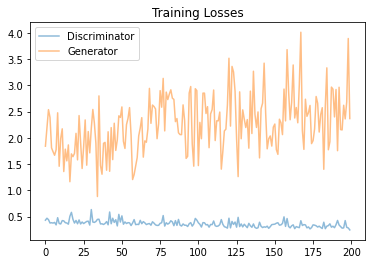

In [44]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()


In [45]:
# torch.save(discriminator.state_dict(), data_path+'discriminator_v02sn_epoch_300.pt')
# torch.save(generator.state_dict(), data_path+'generator_v02sn_epoch_300.pt')


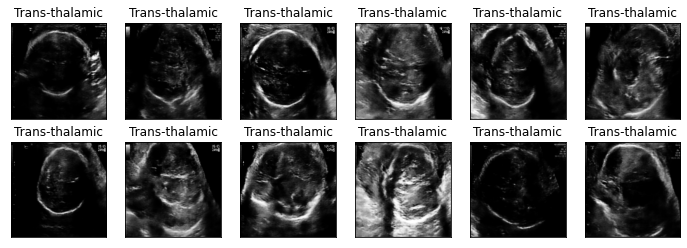

<Figure size 432x288 with 0 Axes>

In [46]:
fixed_latent_vector_0 = torch.randn(12, latent_dim, 1, 1).float().to(device)
fixed_labels_0 = torch.zeros((12,), dtype=int).to(device)
generator.eval()
generated_images = generator(fixed_latent_vector_0, fixed_labels_0)
display(generated_images, fixed_labels_0)


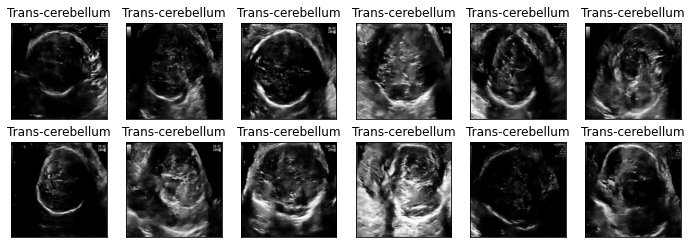

<Figure size 432x288 with 0 Axes>

In [48]:
# fixed_latent_vector_1 = torch.randn(12, latent_dim, 1, 1).float().to(device)
fixed_labels_1 = torch.ones((12,), dtype=int).to(device)
generator.eval()
generated_images = generator(fixed_latent_vector_0, fixed_labels_1)
display(generated_images, fixed_labels_1)
